<a href="https://colab.research.google.com/github/maybje/CE888-Assignment/blob/master/imbalanced_data_pulsar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CE888-Final Assignment: Pulsar Stars
##Project 2: Learning from Imbalanced Datasets (Supervised and Unsupervised Learning)

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re

from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import files
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA, KernelPCA
from sklearn import tree
from sklearn.metrics import (confusion_matrix,recall_score, make_scorer,
                    precision_score,accuracy_score,f1_score,
                    silhouette_score, completeness_score,silhouette_samples)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Load, prepare, and inspect the datasets.
- Import data from GitHub
- After loading the data we examine NA values and decide wether to delete observations or columns based on the proportion of NAs for a specific feature.

In [2]:
# Load the data set on Pulsars
df1 = pd.read_csv('https://raw.githubusercontent.com/maybje/CE888/master/assignment1/data/pulsar_stars.csv')
df1.head(10)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
5,93.570312,46.698114,0.531905,0.416721,1.636288,14.545074,10.621748,131.394004,0
6,119.484375,48.765059,0.031460,-0.112168,0.999164,9.279612,19.206230,479.756567,0
7,130.382812,39.844056,-0.158323,0.389540,1.220736,14.378941,13.539456,198.236457,0
8,107.250000,52.627078,0.452688,0.170347,2.331940,14.486853,9.001004,107.972506,0
9,107.257812,39.496488,0.465882,1.162877,4.079431,24.980418,7.397080,57.784738,0


In [3]:
#Before splitting into test and training set, we explore the size and the class proportions in order to confirm it has the right level of imbalance
print("Shape: ", df1.shape)
#Class proportions

print("Class Proportions:\n", df1["target_class"].value_counts()/df1["target_class"].shape)

Shape:  (17898, 9)
Class Proportions:
 0    0.908426
1    0.091574
Name: target_class, dtype: float64


In [0]:
#Train-Test split into 90-10
X_1=df1.iloc[:,0:-1].copy()
Y_1=df1.iloc[:,-1].copy()

x_1=X_1.copy()
y_1=Y_1.copy()

features1=X_1.columns
x1_train, x1_test, y1_train, y1_test=train_test_split(x_1,y_1, train_size=0.9, random_state=21, stratify=y_1)

In [5]:
#We check the proportions of the sets to confirm the imbalance is preserved
print("Train Shape: ", x1_train.shape)
#Class proportions
print("Train class Proportions:\n", pd.Series(y1_train).value_counts()/y1_train.shape)

print("Test shape: ", x1_test.shape)
#Class proportions
print("Test class Proportions:\n", pd.Series(y1_test).value_counts()/y1_test.shape)

Train Shape:  (16108, 8)
Train class Proportions:
 0    0.908431
1    0.091569
Name: target_class, dtype: float64
Test shape:  (1790, 8)
Test class Proportions:
 0    0.90838
1    0.09162
Name: target_class, dtype: float64


From this point we will work with the train set only. However, every transformation based on the training set will be applied to the test set too using the parameters of functions learned in the training set.

Text(0.5, 0, 'Class')

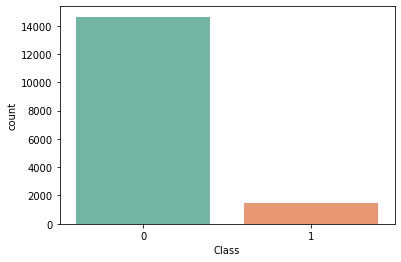

In [0]:
#plot the variables
##Response variable counts
sns.countplot(y1_train,palette="Set2")
plt.xlabel("Class")
#plt.savefig('df1_ir.pdf')
#files.download('df1_ir.pdf')

In [6]:
#We explore if there are any missing values
proportion=[]
for f in features1:
  proportion.append(pd.DataFrame(x1_train, columns=features1)[f].isna().sum(0)/x1_train.shape[0]*100)  
  print(f+": ", "{0:.2f}".format(pd.DataFrame(x1_train, columns=features1)[f].isna().sum(0)/x1_train.shape[0]*100))

print("Traget class: ", "{0:.2f}".format(pd.Series(y1_train).isna().sum(0)/y1_train.shape[0]*100))

 Mean of the integrated profile:  0.00
 Standard deviation of the integrated profile:  0.00
 Excess kurtosis of the integrated profile:  0.00
 Skewness of the integrated profile:  0.00
 Mean of the DM-SNR curve:  0.00
 Standard deviation of the DM-SNR curve:  0.00
 Excess kurtosis of the DM-SNR curve:  0.00
 Skewness of the DM-SNR curve:  0.00
Traget class:  0.00


In [7]:
# Descriptive sattistics in Latex format
pd.DataFrame(x1_train, columns=features1).describe().transpose()  #.to_latex(float_format="%.2f")) #latex format for report

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,16108.0,111.106678,25.710017,5.812500,100.943359,115.132812,127.250000,192.617188
Standard deviation of the integrated profile,16108.0,46.535327,6.825266,24.772042,42.385137,46.941001,50.989427,91.808628
Excess kurtosis of the integrated profile,16108.0,0.478804,1.068813,-1.876011,0.026210,0.222913,0.472468,7.879628
Skewness of the integrated profile,16108.0,1.781831,6.204647,-1.791886,-0.187401,0.201259,0.925085,65.385974
Mean of the DM-SNR curve,16108.0,12.649024,29.509246,0.213211,1.917224,2.788880,5.466555,223.392140
Standard deviation of the DM-SNR curve,16108.0,26.331340,19.521135,7.370432,14.428985,18.403875,28.450093,110.642211
Excess kurtosis of the DM-SNR curve,16108.0,8.315337,4.515681,-3.139270,5.779526,8.457287,10.727517,34.539844
Skewness of the DM-SNR curve,16108.0,105.216565,106.948649,-1.976976,34.778993,83.465311,139.957830,1191.000837


In [0]:
#Since the scales and distribution characteristics of the features are too different we decide to normalize them. 
#In this step we create a copy to visualize them in a boxplot.
#However during the cross-validation steps we will use the original training set and normalize it inside the loop. 
scaler=StandardScaler()
x1_train_norm=x1_train.copy()
x1_train_norm[:]=scaler.fit_transform(x1_train_norm[:])

#We normalize test set using parameters from training set.
x1_test_norm=x1_test.copy()
x1_test_norm[:]=scaler.transform(x1_test_norm[:])

Text(0.5, 0, 'variable')

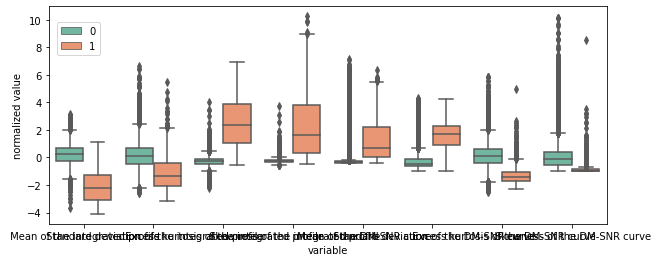

In [0]:
#Boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x="variable", y="value", hue="target_class",\
    data=pd.melt(pd.DataFrame(x1_train).join(pd.Series(y1_train,name='target_class').astype(str)),id_vars=['target_class']),palette="Set2")
plt.legend(bbox_to_anchor=(0.1,0.95))
plt.ylabel("normalized value")
plt.xlabel("variable")
#plt.xticks()
#plt.savefig('df1_box.pdf')
#files.download('df1_box.pdf')

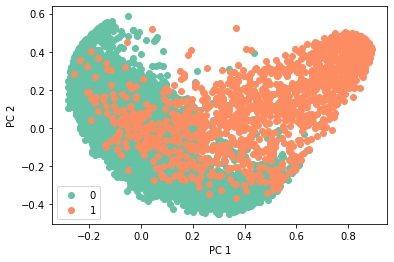

In [0]:
#Scatterplot to the first two principal components using labels
pca = PCA()
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=.01)

x1_train_pca = scikit_kpca.fit_transform(x1_train_norm)

colors = ['#66c2a5','#fc8d62']

for l, c in zip(np.unique(y1_train), colors):
    plt.scatter(x1_train_pca[y1_train == l, 0], 
                x1_train_pca[y1_train == l, 1], 
                c=c, label=l)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend()


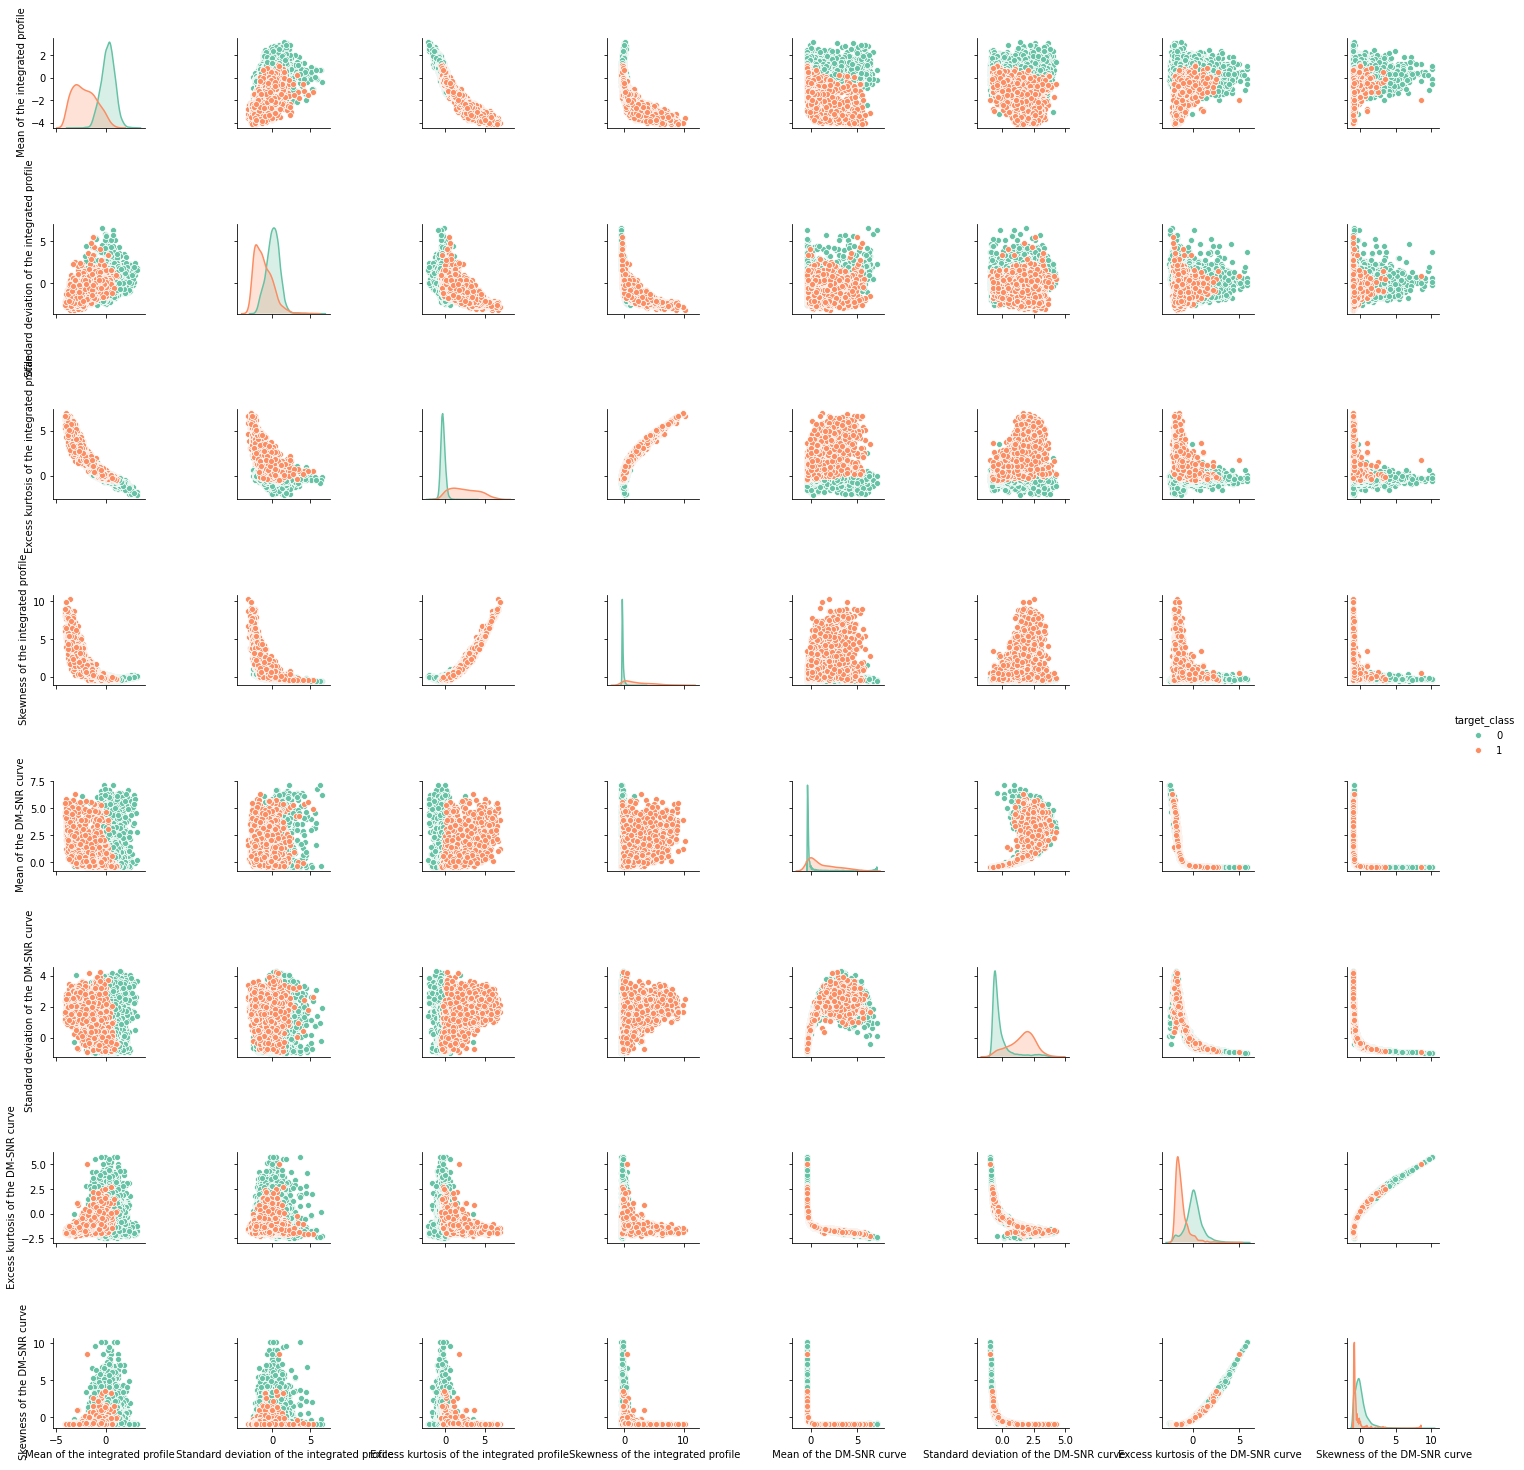

In [0]:
#Scatter and densityplotts of all the variables
sns.pairplot(pd.DataFrame(x1_train_norm).join(pd.Series(y1_train,name="target_class")), hue="target_class", palette="Set2")

Optimal number of features : 7


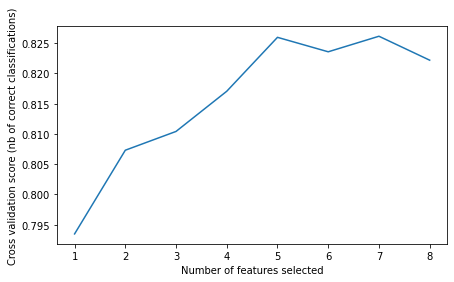

In [0]:
#Recursive Cross-Validated Feature Selection 
#We use the same folds from this point on
k_fold = KFold(n_splits=10)
feature_selection=tree.DecisionTreeClassifier(criterion = "entropy", random_state=21)
f1_scorer=make_scorer(f1_score)
selector=RFECV(feature_selection,cv=k_fold,scoring=f1_scorer)
selector.fit(x1_train_norm,y1_train)
#keeping selected variables and printing names for control
x_best=x1_train_norm.loc[:,selector.get_support()]
xv_best=x1_test_norm.loc[:,selector.get_support()]
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.subplots(figsize=(7,4))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)


Auxiliar functions

In [0]:
#Bootstraping mean
def boostrap_mean(sample, sample_size, n_iterations):
	bootstrap_samples=np.random.choice(sample, size=(n_iterations,sample_size), replace=True)
	mean_array=np.mean(bootstrap_samples, axis=1)
	data_mean=np.mean(mean_array)
	lower=np.percentile(mean_array,2.5)
	upper=np.percentile(mean_array,97.5)
	return data_mean, lower, upper

#Bootstraping standard deviation
def boostrap_std(sample, sample_size, n_iterations):
	bootstrap_samples=np.random.choice(sample, size=(n_iterations,sample_size), replace=True)
	std_array=np.std(bootstrap_samples, axis=1)
	data_std=np.mean(std_array)
	return data_std

#Distance function from the Total within-cluster sum of sqaures to the arch. Used during the Elbow method 
def calc_distance(x1,y1,a,b,c):
  d=abs(a*x1+b*y1+c)/((a*a+b*b)**0.5)
  return d
	
#permutation test: mean difference	p-value
def permutation_test(array1, array2, n_iterations):
  results=[]
  current_mean=np.mean(array1)
  new_mean=np.mean(array2)
  t_obs=new_mean-current_mean
  concat = np.concatenate((array1, array2))
  for i in range(n_iterations):    
    perm = np.random.permutation(concat)
    pcurrent= perm[:len(array1)]
    pnew= perm[len(array1):]
    t_perm=np.mean(pnew)-np.mean(pcurrent)
    if t_perm>t_obs:
      results.append(1)
    else:
      results.append(0)
  p_value=np.sum(results)/n_iterations
  return(p_value)

## 2. DT and RF Baselines

In [0]:
#Empty lists to store results
accuracy_base=[]
f1_base=[]
g_mean_base=[]
metrics_base={"accuracy": accuracy_base, "f1:": f1_base, "g-mean": g_mean_base}

#baselines
dt_base = tree.DecisionTreeClassifier( random_state=21)
rf_base=  RandomForestClassifier(500, random_state=21)
clf=[dt_base,rf_base]

#10-fold cross validation trhough each baseline
for c in clf:
  c_name=c.__class__.__name__
  print("Classifier: %s" % c_name)
  for train_indices, test_indices in k_fold.split(x1_train):
    #Train-validation split using best features
    x1_train_f=x1_train.iloc[train_indices,selector.get_support()].copy()
    x1_train_f[:]=scaler.fit_transform(x1_train_f[:])
    y1_train_f=y1_train.iloc[train_indices].copy()
    x1_val_f=x1_train.iloc[test_indices,selector.get_support()].copy()
    x1_val_f[:]=scaler.transform(x1_val_f[:])
    y1_val_f=y1_train.iloc[test_indices].copy()

    #training baseline
    c.fit(x1_train_f, y1_train_f)
    
    #predicting class and computing metrics
    y_hat=c.predict(x1_val_f)
    f1_f=f1_score(y1_val_f,y_hat)
    acc_f=accuracy_score(y1_val_f,y_hat)
    pr_r=precision_score(y1_val_f,y_hat)
    rec_f=recall_score(y1_val_f,y_hat)
    gmean_f=(pr_r*rec_f)**(0.5)

    #appending to results
    accuracy_base.append([acc_f,c.__class__.__name__])
    f1_base.append([f1_f,c.__class__.__name__])
    g_mean_base.append([gmean_f,c.__class__.__name__])
  
  #printing results for each baseline
  for m, v in metrics_base.items():
    mean,l,u=boostrap_mean(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float), \
                          len(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float)),10000)
    std=boostrap_std(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float), \
                          len(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float)),10000)
    print("%s \nmean: %0.4f, lower: %0.4f, upper: %0.4f, std: %0.4f " % (m,mean, l,u,std))
  print("\n")

Classifier: DecisionTreeClassifier
accuracy 
mean: 0.9685, lower: 0.9660, upper: 0.9711, std: 0.0038 
f1: 
mean: 0.8280, lower: 0.8098, upper: 0.8446, std: 0.0262 
g-mean 
mean: 0.8283, lower: 0.8099, upper: 0.8447, std: 0.0260 


Classifier: RandomForestClassifier
accuracy 
mean: 0.9798, lower: 0.9777, upper: 0.9821, std: 0.0032 
f1: 
mean: 0.8841, lower: 0.8723, upper: 0.8958, std: 0.0180 
g-mean 
mean: 0.8854, lower: 0.8737, upper: 0.8972, std: 0.0176 




## 3. Cluster Analysys

In [0]:
#defining maximum number of clusters
kmax=10
#creating empty lists to store results
accuracy_cluster=[]
f1_cluster=[]
g_mean_cluster=[]
metrics_cluster={"accuracy": accuracy_cluster, "f1:": f1_cluster, "g-mean": g_mean_cluster}

#10-fold CV for cluster-based method
i=1 #iterator variable
for train_indices, test_indices in k_fold.split(x1_train):
  print("Fold: %s" % i) #control message
  #Training-validation split
  x1_train_f=x1_train.iloc[train_indices,selector.get_support()].copy()
  x1_train_f[:]=scaler.fit_transform(x1_train_f[:])
  y1_train_f=y1_train.iloc[train_indices].copy()
  x1_val_f=x1_train.iloc[test_indices,selector.get_support()].copy()
  x1_val_f[:]=scaler.transform(x1_val_f[:])
  y1_val_f=y1_train.iloc[test_indices].copy()

  #####################################
  #Optimal number of clusters selection
  #####################################
  k_optimal=[]  #empty list to store results from each method
  wss=[]  #empty list for sum of squares
  silhouette_avg=[] #empty list for silhouette score

  #compute 'kmax' different clusters
  for k in range(1,kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=21)   #defining algorithm
    cluster=kmeans.fit_predict(x1_train_f) #fit kmeans
    #append silhouette score >1 as for k=1 it is not defined
    if k!=1:
      sil=silhouette_score(x1_train_f, cluster)
      silhouette_avg.append(sil)
    #append sum of squares
    wss.append(kmeans.inertia_)
  
  ################
  #Elbow Method
  ################
  #Rescale sum of squares
  wss=(wss-min(wss))/(max(wss)-min(wss))

  #defining variables to compute distance from sum of squares curve
  #to the arch connecting both extremes (see plot below)
  a=wss[0]-wss[-1]
  b=list(range(1,kmax+1))[-1]-list(range(1,kmax+1))[0]
  c1=list(range(1,kmax+1))[0]*wss[-1]
  c2=list(range(1,kmax+1))[-1]*wss[0]
  c=c1-c2

  #computing distance from sum of squares curve to the arch
  distance=[]
  for k in range(kmax):
    distance.append(calc_distance(list(range(1,kmax+1))[k],wss[k],a,b,c))
  #appending optimal K based on the elbow method
  k_optimal.append(list(range(1,kmax+1))[np.argmax(distance)])

  ###################
  #Silhouette Method 
  ################## 
  #appending optimal K as that with the maximum silhouette score
  k_optimal.append(list(range(2,kmax+1))[np.argmax(silhouette_avg)])

  #choosing the max between the two methods (as it yields better results
  #than selecting the min)
  k_optimal=max(k_optimal)
  print("Best k: %s" % k_optimal)

  ################
  #Learning stage
  ################
  #defining kmeans algorithm
  kmeans = KMeans(n_clusters=k_optimal, random_state=21)
  cluster=kmeans.fit_predict(x1_train_f)   #fitting kmeans algorithm

  #checking whether all clusters have instances from the same class
  i2=0  #iterator
  rf={} #empty dictionary to store Random Forest classifieres
  #iterating through the clusters
  for k in range(k_optimal):    
    #checking if cluster is 'complete' (instances from same class)
    if (y1_train_f[cluster==k].unique().shape[0]==1) is False:
      #defining classifier and storing it in the dictionary
      rf['rf_{0}'.format(k)] = RandomForestClassifier(500, random_state=21)
      #training classifier
      rf[list(rf.keys())[i2]].fit(x1_train_f[cluster==k],y1_train_f[cluster==k])
      i2+=1 #increasing iterator

  ##################
  #predicting Stage
  ##################
  #fitting kmeans on validation set previoulsy trained using training set
  y_hat=kmeans.predict(x1_val_f)
  i3=0   #iterator
  #Loop through clusters to check if it has instances from the same class
  for k in range(k_optimal):
    #checking if cluster is 'complete'
    if (y1_train_f[cluster==k].unique().shape[0]==1) is True:
       #if it is complete, assign the corresponding class to the validation instances in that cluster
      y_hat[y_hat==k]=np.mean(y1_train_f[cluster==k])
    else:
      #if not use the pre-trained classifier to predict the class
      y_hat[y_hat==k]=rf[list(rf.keys())[i3]].predict(x1_val_f[y_hat==k])
      i3+=1 #increase iterator

  #computing metrics
  f1_f=f1_score(y1_val_f,y_hat)
  acc_f=accuracy_score(y1_val_f,y_hat)
  pr_r=precision_score(y1_val_f,y_hat)
  rec_f=recall_score(y1_val_f,y_hat)
  gmean_f=(pr_r*rec_f)**(0.5)

  #appending metrics to lists
  accuracy_cluster.append([acc_f,i])
  f1_cluster.append([f1_f,i])
  g_mean_cluster.append([gmean_f,i])
  i+=1 

print("\n") 
#printing results
for m, v in metrics_cluster.items():
  mean,l,u=boostrap_mean(np.array(v)[:,0].astype(float), \
                        len(np.array(v)[:,0].astype(float)),10000)
  std=boostrap_std(np.array(v)[:,0].astype(float), \
                        len(np.array(v)[:,0].astype(float)),10000)
  print("%s \nmean: %0.4f, lower: %0.4f, upper: %0.4f, std: %0.4f " % (m,mean, l,u,std))



Fold: 1
Best k: 4
Fold: 2
Best k: 4
Fold: 3
Best k: 4
Fold: 4
Best k: 4
Fold: 5
Best k: 4
Fold: 6
Best k: 4
Fold: 7
Best k: 4
Fold: 8
Best k: 4
Fold: 9
Best k: 4
Fold: 10
Best k: 4


accuracy 
mean: 0.9790, lower: 0.9767, upper: 0.9813, std: 0.0034 
f1: 
mean: 0.8779, lower: 0.8653, upper: 0.8909, std: 0.0192 
g-mean 
mean: 0.8800, lower: 0.8678, upper: 0.8929, std: 0.0185 


## 4. Permutation Test

### A) F1 Score

In [0]:
base=["DecisionTreeClassifier","RandomForestClassifier"]#lists with baselines

#compare our method against baselines
for b in base:
  print("F1 Score Mean Difference: Cluster-RF vs %s:" % b)   #message
  cluster=np.array(f1_cluster)[:,0] #getting results from our method
  base=np.array(f1_base)[np.array(f1_base)[:,1]==b][:,0].astype(float)  #baselines results
  diff=np.mean(cluster)-np.mean(base) #computing mean difference
  p_value=permutation_test(base,cluster,1000) #estimating p-value
  print("Difference: %0.4f, p-value: %0.4f" % (diff, p_value))  #printing p-value


F1 Score Mean Difference: Cluster-RF vs DecisionTreeClassifier:
Difference: 0.0500, p-value: 0.0000
F1 Score Mean Difference: Cluster-RF vs RandomForestClassifier:
Difference: -0.0061, p-value: 0.7260


### B) G-mean 

In [0]:
base=["DecisionTreeClassifier","RandomForestClassifier"]  #lists with baselines

#compare our method against baselines
for b in base:
  print("G-mean Score Mean Difference: Cluster-RF vs %s:" % b)  #message
  cluster=np.array(g_mean_cluster)[:,0]    #getting results from our method
  base=np.array(g_mean_base)[np.array(g_mean_base)[:,1]==b][:,0].astype(float) #baselines results
  diff=np.mean(cluster)-np.mean(base) #computing mean difference
  p_value=permutation_test(base,cluster,1000) #estimating p-value
  print("Difference: %0.4f, p-value: %0.4f" % (diff, p_value))   #printing p-value

G-mean Score Mean Difference: Cluster-RF vs DecisionTreeClassifier:
Difference: 0.0516, p-value: 0.0000
G-mean Score Mean Difference: Cluster-RF vs RandomForestClassifier:
Difference: -0.0055, p-value: 0.7090


### C) Accuracy

In [0]:
base=["DecisionTreeClassifier","RandomForestClassifier"]#lists with baselines

#compare our method against baselines
for b in base:
  print("Accuracy Mean Difference: Cluster-RF vs %s:" % b)  #message
  cluster=np.array(accuracy_cluster)[:,0]  #getting results from our method
  base=np.array(accuracy_base)[np.array(accuracy_base)[:,1]==b][:,0].astype(float)  #baselines results
  diff=np.mean(cluster)-np.mean(base) #computing mean difference
  p_value=permutation_test(base,cluster,1000) #estimating p-value
  print("Difference: %0.4f, p-value: %0.4f" % (diff, p_value))  #printing p-value

Accuracy Mean Difference: Cluster-RF vs DecisionTreeClassifier:
Difference: 0.0106, p-value: 0.0000
Accuracy Mean Difference: Cluster-RF vs RandomForestClassifier:
Difference: -0.0008, p-value: 0.6810


In [0]:
#converting results to data frames to plot them

m_t=pd.DataFrame([])  #empty data frame
#iterating through cluster-based method results
for m, v in metrics_cluster.items():
  if m!="accuracy":
    m_i=pd.DataFrame(v) #converting results to dataframe
    m_i["metric"]=m #adding results
    m_i.iloc[:,1]="cluster" #indicator column
    m_t=pd.concat([m_t,m_i], ignore_index=True) #appending to empy dataframe

#iterating through baseline results
for m, v in metrics_base.items():
  if m!="accuracy":
    m_i=pd.DataFrame(v) #converting results to dataframe
    m_i["metric"]=m  #adding results
    m_t=pd.concat([m_t,m_i], ignore_index=True) #appending to empy dataframe
 

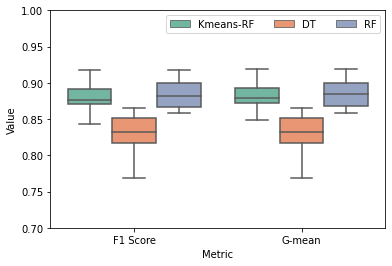

In [0]:
#Plotting results
plot=sns.boxplot(m_t.iloc[:,2],m_t.iloc[:,0],  hue=m_t.iloc[:,1],
                 data=m_t, palette="Set2")
handles, _ = plot.get_legend_handles_labels()

plt.legend( title="", fontsize='small', fancybox=True)
plot.legend(handles, ["Kmeans-RF", "DT", "RF"],ncol=3)
plot.set(xlabel='Metric', ylabel='Value') #labeling axis
plot.set_ylim((.7,1))
plot.set_xticks(range(m_t.iloc[:,2].unique().shape[0])) 
plot.set_xticklabels(["F1 Score", "G-mean"])
plt.savefig("pulsar_box.png", bbox_inches='tight') #saving figure

### 5. Test Set Results

In [0]:
#####################################
#Optimal number of clusters selection
#####################################
k_optimal=[]  #empty list to store results from each method
wss=[]  #empty list for sum of squares
silhouette_avg=[] #empty list for silhouette score
#Iterating thorugh the maximum number of clusters to be tested
for k in range(1,kmax+1):
  kmeans = KMeans(n_clusters=k, random_state=21)
  cluster=kmeans.fit_predict(x_best)
  if k!=1:
      sil=silhouette_score(x_best, cluster)
      silhouette_avg.append(sil)
  wss.append(kmeans.inertia_)

#Elbow Method
#Rescale sum of squares
wss=(wss-min(wss))/(max(wss)-min(wss))

#defining variables to compute distance from sum of squares curve
#to the arch connecting both extremes (see plot below)
a=wss[0]-wss[-1]
b=list(range(1,kmax+1))[-1]-list(range(1,kmax+1))[0]
c1=list(range(1,kmax+1))[0]*wss[-1]
c2=list(range(1,kmax+1))[-1]*wss[0]
c=c1-c2

#computing distance from sum of squares curve to the arch
distance=[]
for k in range(kmax):
  distance.append(calc_distance(list(range(1,kmax+1))[k],wss[k],a,b,c))

#appending optimal K based on the elbow method
k_optimal.append(list(range(1,kmax+1))[np.argmax(distance)])

###################
#Silhouette Method 
################## 
#appending optimal K as that with the maximum silhouette score
k_optimal.append(list(range(2,kmax+1))[np.argmax(silhouette_avg)])

#choosing the max between the two methods (as it yields better results
#than selecting the min)
k_optimal=max(k_optimal)
print("Best k: %s" % k_optimal) #print optimal K

################
#Learning stage
################
#defining kmeans algorithm
kmeans = KMeans(n_clusters=k_optimal, random_state=21)
cluster=kmeans.fit_predict(x_best)

#checking whether all clusters have instances from the same class
i2=0  #iterator
rf={} #empty dictionary to store Random Forest classifieres
#iterating through the clusters
for k in range(k_optimal):
  #checking if cluster is 'complete' (instances from same class)
  if (y1_train[cluster==k].unique().shape[0]==1) is False:
    #defining classifier and storing it in the dictionary
    rf['rf_{0}'.format(k)] = RandomForestClassifier(500, random_state=21)
     #training classifier
    rf[list(rf.keys())[i2]].fit(x_best[cluster==k],y1_train[cluster==k])
    i2+=1

##################
#predicting Stage
##################
#fitting kmeans on validation set previoulsy trained using training set
y_hat=kmeans.predict(xv_best)
i3=0  #iterator
#Loop through clusters to check if it has instances from the same class
for k in range(k_optimal):
  #checking if cluster is 'complete'
  if (y1_train[cluster==k].unique().shape[0]==1) is True:
    #if it is complete, assign the corresponding class to the validation instances in that cluster
    y_hat[y_hat==k]=np.mean(y1_train[cluster==k])
  else:
    #if not use the pre-trained classifier to predict the class
    y_hat[y_hat==k]=rf[list(rf.keys())[i3]].predict(xv_best[y_hat==k])
    i3+=1

#computing metrics
f1_t=f1_score(y1_test,y_hat)
acc_t=accuracy_score(y1_test,y_hat)
pr_t=precision_score(y1_test,y_hat)
rec_t=recall_score(y1_test,y_hat)
gmean_t=(pr_t*rec_t)**(0.5)

#pritning results
metrics_test={"accuracy": acc_t, "f1:": f1_t, "g-mean": gmean_t}
for m, v in metrics_test.items():
  print("Test %s: %0.4f" % (m,v))



Best k: 4
Test accuracy: 0.9782
Test f1:: 0.8730
Test g-mean: 0.8750


### 6. Additional Plots

- Silhouette Plots (implementation taken from sklearn documentation)

For n_clusters = 2 The average silhouette_score is : 0.6409697523505463
For n_clusters = 3 The average silhouette_score is : 0.3242562808336295
For n_clusters = 4 The average silhouette_score is : 0.36250768854167115
For n_clusters = 5 The average silhouette_score is : 0.3083622889615306
For n_clusters = 6 The average silhouette_score is : 0.30274306290371616
For n_clusters = 7 The average silhouette_score is : 0.2882789260794449
For n_clusters = 8 The average silhouette_score is : 0.2616041942415021
For n_clusters = 9 The average silhouette_score is : 0.24208610870130742
For n_clusters = 10 The average silhouette_score is : 0.23944747137183722


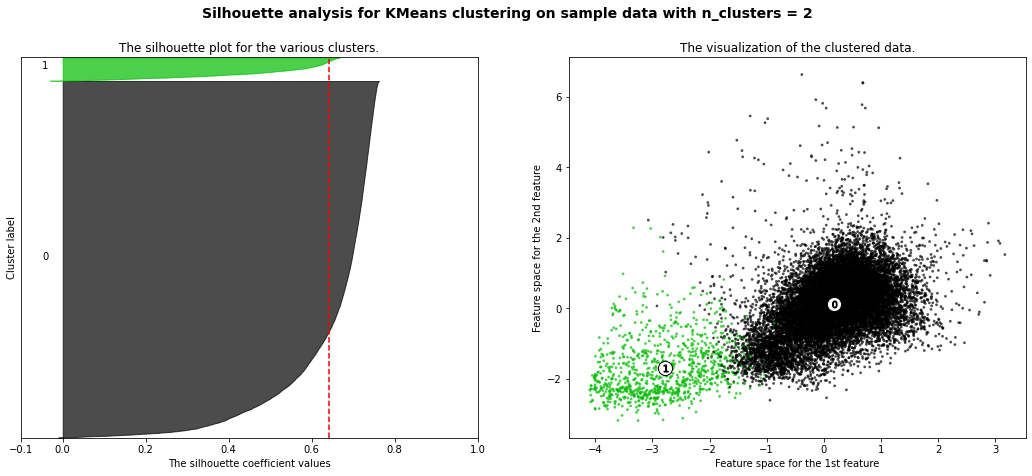

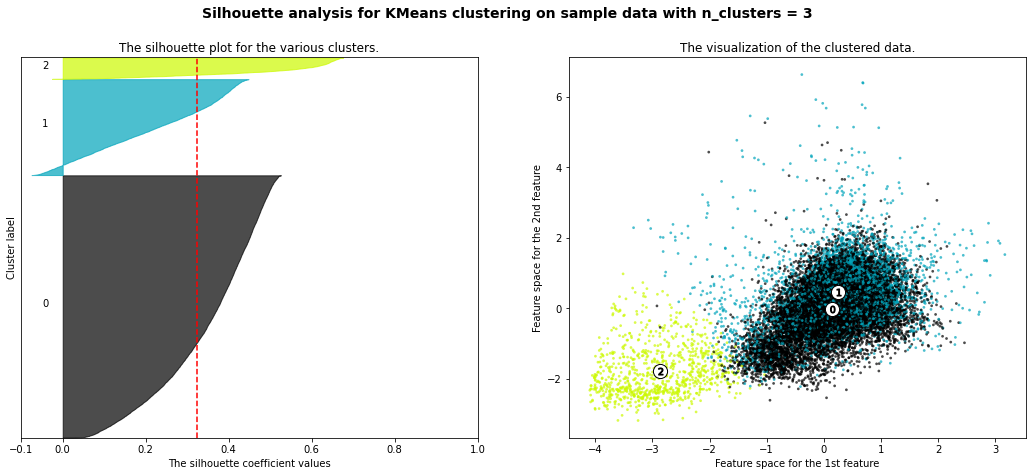

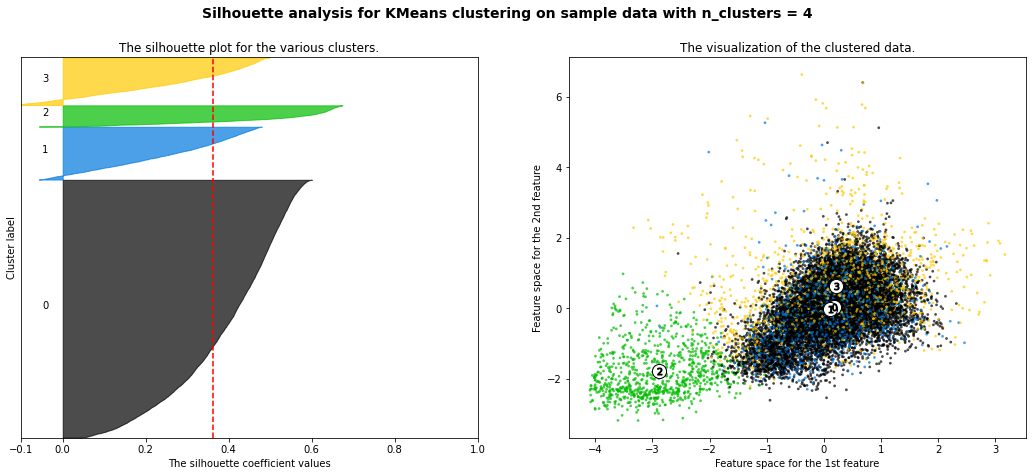

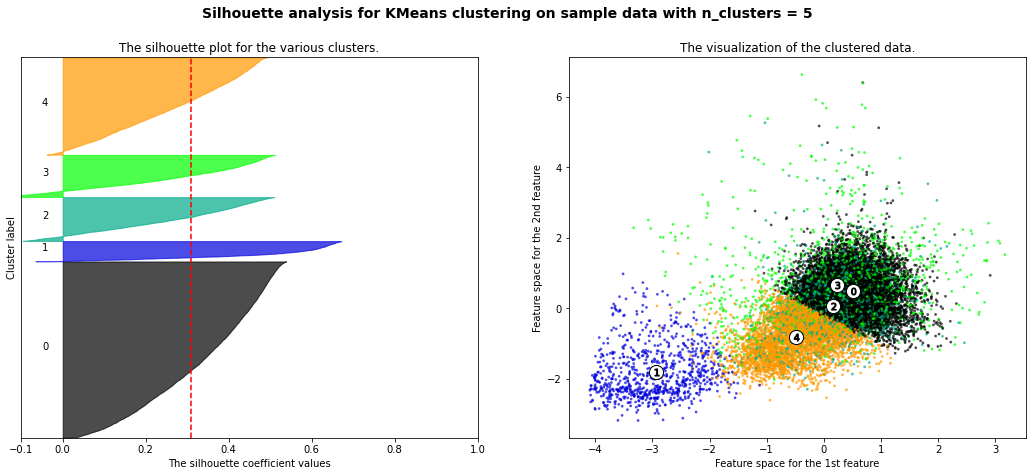

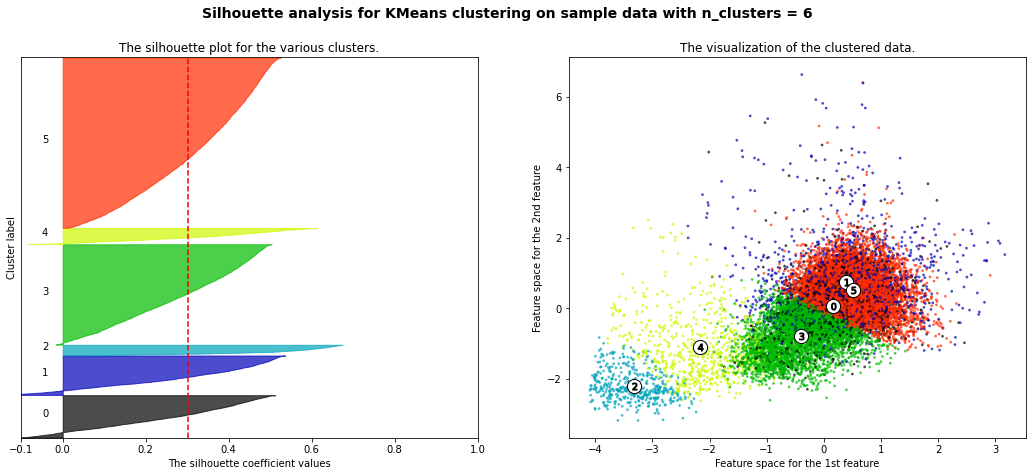

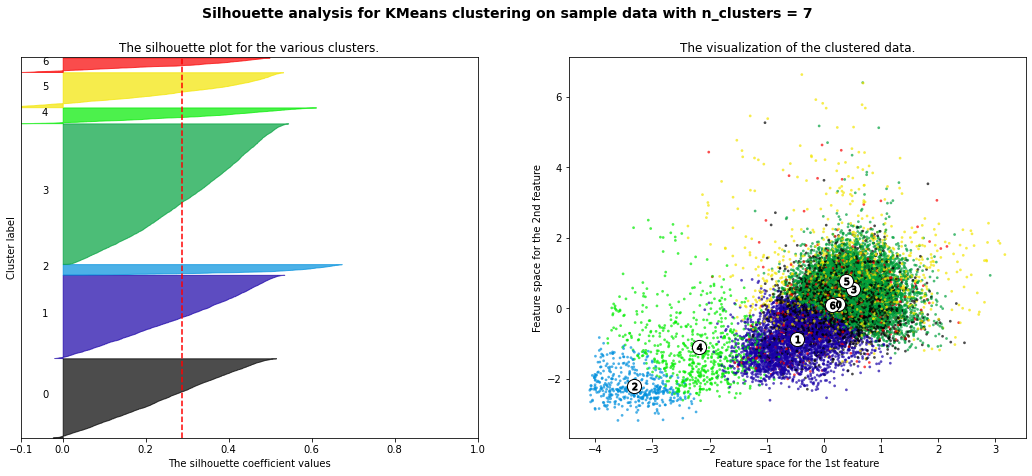

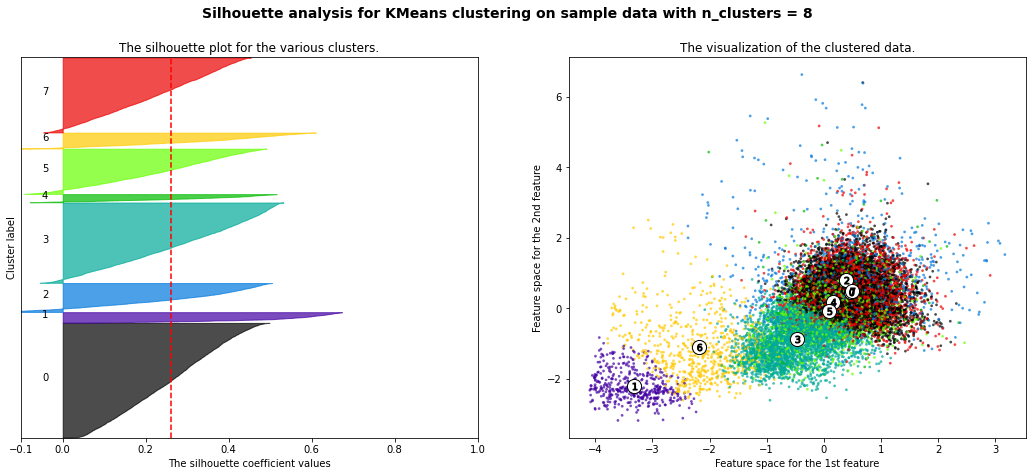

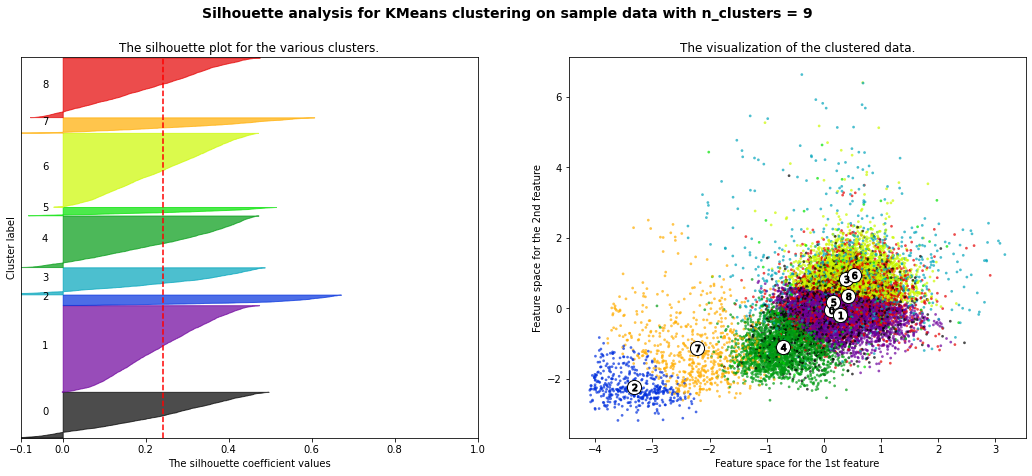

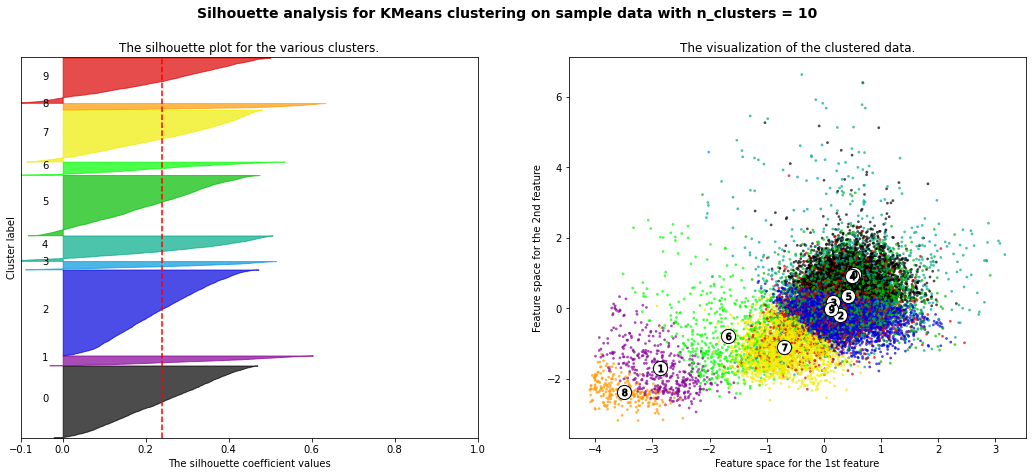

In [0]:
range_n_clusters =list(range(2,kmax+1))
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_best) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_best)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_best, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_best, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_best.iloc[:, 0], x_best.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

- Elbow method

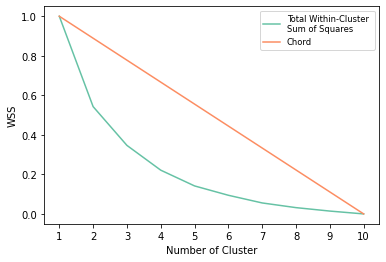

In [0]:
#computing clusters for range(1,kmax)
wss=[]
for k in range(1,kmax+1):
  kmeans = KMeans(n_clusters=k, random_state=21)
  cluster=kmeans.fit_predict(x_best)
  wss.append(kmeans.inertia_)

#Elbow Method
wss=(wss-min(wss))/(max(wss)-min(wss))

a=wss[0]-wss[-1]
b=list(range(1,kmax+1))[-1]-list(range(1,kmax+1))[0]
c1=list(range(1,kmax+1))[0]*wss[-1]
c2=list(range(1,kmax+1))[-1]*wss[0]
c=c1-c2

distance=[]
for k in range(kmax):
  distance.append(calc_distance(list(range(1,kmax+1))[k],wss[k],a,b,c))

#plot
K=list(range(1,kmax+1))
plot=plt.plot(K, wss,label="Total Within-Cluster \nSum of Squares",color='#66c2a5')
plt.plot([K[0],K[-1]],[wss[0],wss[-1]],label="Chord",color='#fc8d62')
plt.legend( title="", fontsize='small', fancybox=True)
#plot.legend(handles, ["Kmeans-RF", "DT", "RF"],ncol=3)
#plot.set(xlabel='Number of Cluster', ylabel='WSS') #labeling axis
plt.xlabel('Number of Cluster')
plt.ylabel('WSS')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.savefig("pulsar_elbow.png", bbox_inches='tight') #saving figure